Make sure you fill your name and NetID below:

In [1]:
NAME = "Zain Mughal"
NET_ID = "zmm21"

---

# Policy Gradients

In this notebook, you will implement policy gradients with a baseline.

As in the previous assignments, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
x = 3.7
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.


## Setup

First let's install and import some libraries that will be useful in this assignment.

In [2]:
!pip install gym
!pip install autorom
!AutoROM -y
!pip install --upgrade "gym[atari]==0.21.0"
!pip uninstall ale-py --yes
!pip install ale-py
!pip uninstall box2d-py --yes
!pip install box2d-py
!pip uninstall pyvirtualdisplay --yes
!pip install pyvirtualdisplay
!pip install pyglet

!apt-get install -y xvfb python-opengl ffmpeg

import gym
import ale_py

# make sure the gym version is 0.21.0
print('gym:', gym.__version__)
print('ale_py:', ale_py.__version__)

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.7/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.7/dist-packages/AutoROM/roms/bank_heist.bin
Installed /usr/l

In [3]:
from collections import deque

import gym
from gym import spaces
# from gym.wrappers import Monitor
from gym.wrappers import RecordVideo
import numpy as np
import torch
from torch import nn

import random
import sys, math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [4]:
# setup display for showing videos

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
def seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')
device = torch.device('cuda:0')

Good to go!


## Policy Gradients

The reinforcement learning objective is to learn a $\theta^*$ that maximizes the objective function $J(\theta)$:

\begin{align}
\theta^* &= {\arg \max}_\theta J(\theta) \\
&= {\arg \max}_\theta \mathbb{E}_{\tau \sim \pi_{\theta}(\tau)} G(\tau) \\
\end{align}

$\tau$ is a rollout of length $T$, $G(\tau) = \sum_t r(s_t, a_t)$ is the sum of rewards over $\tau$, and $\pi$ is the policy:

$$ \pi_\theta(\tau) = p(s_1, a_1, ..., s_T, a_T) = p(s_1) \prod_{t=1}^T \pi_\theta(a_t|s_t) p(s_{t+1}|s_t, a_t) $$

Policy gradients optimize this objective by directly taking the gradient of $J(\theta)$:

\begin{align}
\nabla_\theta J(\theta) &= \nabla_\theta \mathbb{E}_{\tau \sim \pi_{\theta}(\tau)} G(\tau) \\
&= \nabla_\theta \int \pi_\theta(\tau) G(\tau) d\tau \\
&= \int \pi_\theta(\tau) \nabla_\theta \log \pi_\theta(\tau) G(\tau) d\tau \\
&= \mathbb{E}_{\tau \sim \pi_{\theta}(\tau)} \big[ \nabla_\theta \log \pi_\theta (\tau) G(\tau) \big]
\end{align}

To get the third equation, we used the log-gradient trick discussed in lecture. We can approximate the expectation by taking a batch of $N$ sampled trajectories:

\begin{align}
\nabla_\theta J(\theta) &\approx \frac{1}{N} \sum_{i=1}^N \nabla_\theta \log \pi_\theta (\tau_i) G(\tau_i) \\
&\approx \frac{1}{N} \sum_{i=1}^N \Big( \sum_{t=1}^T \nabla_\theta \log \pi_\theta (a_{it}|s_{it}) \Big) \Big( \sum_{t=1}^T r(s_{it}, a_{it}) \Big) \\
\end{align}

This estimate usually has high variance, so for this assignment we will utilize a few methods to reduce the variance.

### Reward-to-go

Since the policy cannot affect rewards in the past, we can modify the sum of rewards term to only include rewards for timesteps after the timestep for which we are taking the action. The modified objective looks like:

\begin{align}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N \sum_{t=1}^T \nabla_\theta \log \pi_\theta (a_{it}|s_{it})  \Big( \sum_{t'=t}^T r(s_{it'}, a_{it'}) \Big) \\
\end{align}

The summation for the reward term now starts at t instead of 1. This is called the "reward-to-go".

### Discount factor

We also include a discount factor, which encourages the agent to focus on more immediate rewards vs. rewards further in the future. Given the discount factor $\gamma$ and combining with the reward-to-go, we have:

\begin{align}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N \sum_{t=1}^T \nabla_\theta \log \pi_\theta (a_{it}|s_{it})  \Big( \sum_{t'=t}^T \gamma^{t'-t} r(s_{it'}, a_{it'}) \Big) \\
\end{align}

### Baseline

To further reduce variance, we subtract a state-dependent baseline $b(s)$ from the sum of rewards:

$$ \nabla_\theta J(\theta) = \nabla_\theta \mathbb{E}_{\tau \sim \pi_{\theta}(\tau)} [G(\tau) - b(s)] $$

For this assignment, we use a value function $V_\phi^\pi(s_t)$ as the baseline, which is trained to estimate the sum of future rewards from a particular state. $V_\phi^\pi(s_t)$ will be a neural network with parameters $\phi$ that is trained by minimizing the mean-squared error between $V_\phi^\pi(s_t)$ and the reward-to-go:

$$ MSE\Big(V_\phi^\pi(s_t), \sum_{t'=t}^T \gamma^{t'-t} r(s_{it'}, a_{it'})\Big) $$

The approximate policy gradient is now:

\begin{align}
\nabla_\theta J(\theta) &\approx \frac{1}{N} \sum_{i=1}^N \sum_{t=1}^T \nabla_\theta \log \pi_\theta (a_{it}|s_{it})  \Big( \Big( \sum_{t'=t}^T \gamma^{t'-t} r(s_{it'}, a_{it'}) \Big) - V_\phi^\pi(s_{it}) \Big) \\
\nabla_\theta J(\theta) &\approx \frac{1}{N} \sum_{i=1}^N \sum_{t=1}^T \nabla_\theta \log \pi_\theta (a_{it}|s_{it}) \hat{A}_t \\
\end{align}

where $\hat{A}_t$ is referred to as the advantage. As an aside, note that our implementation of the advantage uses a single trajectory to estimate the expected sum of rewards from a state, but there are other choices for this that may further reduce variance, such as using a TD error ($r_t + \gamma V_\phi^\pi(s_{t+1}) - V_\phi^\pi(s_{t})$).

Lastly, we normalize our advantages so that they have mean 0 and standard deviation 1. This has also been shown to reduce variance.



## Policy and Baseline Networks

Let's start by implementing the networks for the policy and the baseline value function. We will use the following network for the policy:

- Linear layer with 16 output units
- ReLU
- Linear layer with num_actions outputs

In [7]:
def create_mlp_policy_net(ob_dim, num_actions):
    ##############################################################################
    # TODO: Implement the network described above.
    ##############################################################################
    # Replace "pass" statement with your code
    return nn.Sequential(
      nn.Linear(ob_dim, 16),
      nn.ReLU(),
      nn.Linear(16, num_actions),
    )
    # END OF YOUR CODE

We will use the following network for the baseline:

- Linear layer with 128 hidden units
- ReLU
- Linear layer with 1 output

In [8]:
def create_mlp_baseline_net(ob_dim):
    ##############################################################################
    # TODO: Implement the network described above.
    ##############################################################################
    # Replace "pass" statement with your code
    return nn.Sequential(
        nn.Linear(ob_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )
    # END OF YOUR CODE

## Policy Gradient

Now let's implement the PG class. Read the code to understand what it is doing (start with `train`). Then you will need to add your implementation to the following methods:

Read the `#TODO` comments carefully for instructions of the parts you need to implement.

In [9]:
class PG:
    def __init__(self, env, config):
        """
        Args
            env: gym environment
            config: dictionary
                configuration parameters specific to the environment
        """
        self.env = env
        self.config = config
        self.observation_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.lr = self.config['lr']

        policy_net_func = config['policy_net_func']
        self.policy_net = policy_net_func(
            self.observation_dim,
            self.action_dim
        ).to(self.config['device'])
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=self.config['lr'])

        baseline_net_func = config['baseline_net_func']
        self.baseline_net = baseline_net_func(self.observation_dim).to(self.config['device'])
        self.baseline_optimizer = torch.optim.Adam(self.baseline_net.parameters(), lr=self.config['lr'])
        
        
    def sample_path(self, env, num_episodes=None):
        """
        Sample paths (trajectories) from the environment.

        Args:
            env: open AI Gym envinronment
            num_episodes: the number of episodes to be sampled
                if none, sample one batch (size indicated by config file)

        Returns:
            paths: a list of paths. Each path in paths is a dictionary with
                path["observation"] a tensor of ordered observations in the path
                path["actions"] a tensor of the corresponding actions in the path
                path["reward"] a tensor of the corresponding rewards in the path
            total_rewards: the sum of all rewards encountered during this "path"

        You do not have to implement anything in this function, but you will need to
        understand what it returns, and it is worthwhile to look over the code
        just so you understand how we are taking actions in the environment
        and generating batches to train on.
        """
        episode = 0
        episode_rewards = []
        paths = []
        t = 0

        while (num_episodes or t < self.config['batch_size']):
            state = env.reset()
            states, actions, action_logits, rewards = [], [], [], []
            episode_reward = 0

            for step in range(self.config['max_ep_len']):
                states.append(state)
                action_out = self.policy_net(torch.as_tensor(state, device=self.config['device'], dtype=torch.float32))
                action = torch.multinomial(torch.softmax(action_out, dim=-1), 1)[0].item()
                state, reward, done, info = env.step(action)

                actions.append(action)
                action_logits.append(action_out)
                rewards.append(reward)
                episode_reward += reward
                t += 1
                if (done or step == self.config['max_ep_len']-1):
                    episode_rewards.append(episode_reward)
                    break

                if (not num_episodes) and t == self.config['batch_size']:
                    break

            path = {
                "observation" : torch.from_numpy(np.array(states)).to(self.config['device']).float(),
                "reward" : torch.from_numpy(np.array(rewards)).to(self.config['device']).float(),
                "action" : torch.from_numpy(np.array(actions)).to(self.config['device']),
                "action_logit" : torch.stack(action_logits),
            }
            paths.append(path)
            episode += 1
            if num_episodes and episode >= num_episodes:
                break

        return paths, episode_rewards
      
      
    def get_returns(self, paths):
        """
        Calculate the returns G_t for each timestep. We use the return-to-go
        here so we only calculate the return from t until the end of the 
        trajectory.

        Args:
                paths: recorded sample paths.  See sample_path() for details.

        Return:
                returns: return G_t for each timestep

        After acting in the environment, we record the observations, actions, and
        rewards. To get the advantages that we need for the policy update, we have
        to convert the rewards into returns, G_t, which are themselves an estimate
        of Q^π (s_t, a_t):

           G_t = r_t + γ r_{t+1} + γ^2 r_{t+2} + ... + γ^{T-t} r_T

        where T is the last timestep of the episode.

        TODO: compute and return G_t for each timestep. Use self.config['gamma'].
        """

        all_returns = []
        for path in paths:
            rewards = path["reward"]
            returns = []
            ##############################################################################
            # TODO: Calculate the returns-to-go G_t and set the result to `returns`.
            ##############################################################################
            # Replace "pass" statement with your code
            # reversed_rewards = np.flip(rewards,0)
            # g_t = 0
            # for r in reversed_rewards:
            #     g_t = r + self.gamma*g_t
            #     returns.insert(0, g_t)
            rev_rewards = torch.flip(rewards,(0,))
            returns = [rev_rewards[0]]

            for i in range(1, rev_rewards.shape[0]):
              returns.append(rev_rewards[i] + self.config['gamma']*returns[i - 1])
            
            returns.reverse()
            # END OF YOUR CODE
            all_returns.append(torch.as_tensor(returns, device=self.config['device']))
        returns = torch.cat(all_returns)

        return returns
      
    def calculate_advantage(self, returns, observations):
        """
        Calculate the advantage

        Args:
                returns: all discounted future returns for each step
                observations: observations
        Returns:
                adv: Advantage
                baseline: calculated baseline for each step

        Calculate the advantages, using baseline adjustment if necessary,
        and normalizing the advantages if necessary.
        If neither of these options are True, just return returns.
        """
        adv = returns
        baseline = None
        ##############################################################################
        # TODO:
        # If config['use_baseline'] = False and config['normalize_advantage'] = False,
        # then the "advantage" is just going to be the returns (and not actually
        # an advantage).
        #
        # if config['use_baseline'], then we need to evaluate the baseline and subtract
        #   it from the returns to get the advantage.
        #   HINT: evaluate the self.baseline_net
        # 
        # if config['normalize_advantage']:
        #   after doing the above, normalize the advantages so that they have a mean of 0
        #   and standard deviation of 1.
        #
        # Also return the baseline if it is calculated.
        ##############################################################################
        # Replace "pass" statement with your code
        if self.config['use_baseline']:
          baseline = self.baseline_net(observations).squeeze(-1)
          adv = returns - baseline
        
        if self.config['normalize_advantage']:
          adv = (adv - torch.mean(adv)) / torch.std(adv)
        # END OF YOUR CODE
        return adv, baseline
      
    def update_baseline(self, baseline, returns):
        """
        Updates the baseline by computing the loss and runing a gradient step

        Args:
                baseline: baseline for each step
                returns: all discounted future returns for each step
        Returns:
                baseline_loss
        """
        ##############################################################################
        # TODO: Use an MSELoss between baseline and returns for the baseline_loss.
        # Use self.baseline_optimizer to perform a gradient step.
        # Return the computed baseline_loss.
        ##############################################################################
        # Replace "pass" statement with your code
        baseline_loss = 0
        baseline_loss = torch.nn.MSELoss()(baseline, returns)
        self.baseline_optimizer.zero_grad()
        baseline_loss.backward()
        self.baseline_optimizer.step()
        # END OF YOUR CODE
        return baseline_loss

    def update_policy(self, action_logits, actions, advantages):
        """
        Updates the policy by computing the loss and runing a gradient step

        Args:
                action_logits:
                actions:
                advantages:
        Returns:
                loss
        """
        ##############################################################################
        # TODO: Compute the loss for the policy and perform a gradient step
        # Hint: This can be done by using CrossEntropyLoss between the action_logits and
        # actions. Then multiply elementwise with advantages and take the mean to get
        # the loss. The gradient of this loss is equivalent to the gradient of the 
        # approximate objective described above.
        #
        # Use self.optimizer to perform a gradient step.
        # Return the computed loss.
        ##############################################################################
        # Replace "pass" statement with your code
        loss = 0
        loss_action = torch.nn.CrossEntropyLoss(reduction='none')(action_logits, actions.long())
        loss = torch.mean(loss_action * (advantages.detach()))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # END OF YOUR CODE
        return loss
      
    def train(self):
        """
        Performs training
        """
        last_eval = 0

        scores_eval = [] # list of scores computed at iteration time

        for t in range(self.config['num_batches']):
            # collect a minibatch of samples
            paths, total_rewards = self.sample_path(self.env)

            scores_eval = scores_eval + total_rewards
            observations = torch.cat([path["observation"] for path in paths])
            actions = torch.cat([path["action"] for path in paths])
            action_logits = torch.cat([path["action_logit"] for path in paths])
            rewards = torch.cat([path["reward"] for path in paths])
            # compute Q-val estimates (discounted future returns) for each time step
            returns = self.get_returns(paths)
            advantages, baseline = self.calculate_advantage(returns, observations)

            # run training operations
            if self.config['use_baseline']:
                baseline_loss = self.update_baseline(baseline, returns)

            self.update_policy(
                    action_logits,
                    actions,
                    advantages,
            )

            # compute reward statistics for this batch and log
            avg_reward = np.mean(total_rewards)
            sigma_reward = np.sqrt(np.var(total_rewards) / len(total_rewards))
            msg = "Average reward: {:04.2f} +/- {:04.2f}".format(avg_reward, sigma_reward)
            print(msg)

            if self.config['video'] and t % self.config['video_freq'] == 0:
                # show a video of our policy in action
                with torch.no_grad():
                    self.video()


        print("- Training done.")
        return scores_eval
        
    def evaluate(self, env=None, num_episodes=1):
      """
      Evaluates the return for num_episodes episodes.
      """
      if env==None: env = self.env
      paths, rewards = self.sample_path(env, num_episodes)
      avg_reward = np.mean(rewards)
      sigma_reward = np.sqrt(np.var(rewards) / len(rewards))
      msg = "Average reward: {:04.2f} +/- {:04.2f}".format(avg_reward, sigma_reward)
      print(msg)
      return avg_reward

    def video(self):
        """
        Re create an env and show a video for one episode
        """
        print("Showing video...")
        def show_video():
          mp4list = glob.glob('video/*.mp4')
          if len(mp4list) > 0:
            mp4 = mp4list[0]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                     </video>'''.format(encoded.decode('ascii'))))
          else: 
            print("Could not find video")


        def wrap_env(env):
#           env = Monitor(env, './video', force=True)
          env = RecordVideo(env, './video')        
          return env
        
        env = gym.make(self.config['env_name'])
        env = wrap_env(env)
        self.evaluate(env, 1)
        env.close()
        show_video()


## Policy Gradient on Cartpole

We test our implementation on several classic control problems (https://gym.openai.com/envs/#classic_control). We start with Cartpole, where the goal is to prevent a pole from falling over by moving the underlying cart left and right. Your agent should be able to obtain the maximum reward of 200 at some point during training.

In [10]:
def run(env, config):
    env.seed(config['seed'])
    env.action_space.seed(config['seed'])
    
    pg = PG(env, config)
        
    rewards = pg.train()
    
    if config['video']:
        # show final video
        pg.video()
        
    print('Done!')
    return pg, rewards

In [11]:
def run_cartpole():
    config = {
        'seed': 1,
        'env_name': 'CartPole-v0',
        'lr': 3e-2,
        'num_batches': 100,
        'batch_size': 1000,
        'max_ep_len': 1000,
        'gamma': 1.0,
        'policy_net_func': create_mlp_policy_net,
        'baseline_net_func': create_mlp_baseline_net,
        'use_baseline': True,
        'normalize_advantage': True,
        'device': device,
        'video': True,
        'video_freq': 20,
    }
    
    torch.manual_seed(config['seed'])
    np.random.seed(config['seed'])
    random.seed(config['seed'])
    
    env = gym.make(config['env_name'])
    pg_agent, rewards = run(env, config)
    return pg_agent, rewards, env
cartpole_pg_agent, cartpole_rewards, cartpole_env = run_cartpole()

Average reward: 23.12 +/- 2.01
Showing video...
Average reward: 35.00 +/- 0.00


Average reward: 35.61 +/- 4.56
Average reward: 25.44 +/- 1.71
Average reward: 41.96 +/- 7.87
Average reward: 41.91 +/- 4.07
Average reward: 42.78 +/- 3.84
Average reward: 48.68 +/- 7.48
Average reward: 99.30 +/- 13.38
Average reward: 66.27 +/- 10.55
Average reward: 81.50 +/- 9.42
Average reward: 85.27 +/- 11.08
Average reward: 89.27 +/- 5.95
Average reward: 103.00 +/- 8.36
Average reward: 121.00 +/- 16.84
Average reward: 140.43 +/- 11.96
Average reward: 134.67 +/- 24.26
Average reward: 141.71 +/- 19.87
Average reward: 161.50 +/- 12.25
Average reward: 173.60 +/- 12.75
Average reward: 152.50 +/- 23.86
Average reward: 190.60 +/- 6.41
Showing video...


/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: 200.00 +/- 0.00


Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 180.80 +/- 17.17
Average reward: 200.00 +/- 0.00
Average reward: 194.60 +/- 4.83
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Showing video...


/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: 200.00 +/- 0.00


Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 197.80 +/- 1.97
Average reward: 185.00 +/- 13.42
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Showing video...


/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: 200.00 +/- 0.00


Average reward: 199.40 +/- 0.54
Average reward: 181.00 +/- 12.98
Average reward: 199.40 +/- 0.36
Average reward: 186.00 +/- 12.52
Average reward: 166.17 +/- 17.90
Average reward: 163.00 +/- 17.55
Average reward: 176.40 +/- 13.32
Average reward: 196.80 +/- 2.86
Average reward: 184.00 +/- 14.31
Average reward: 173.80 +/- 17.04
Average reward: 178.60 +/- 15.07
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 197.00 +/- 2.68
Average reward: 200.00 +/- 0.00
Average reward: 196.60 +/- 3.04
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 195.40 +/- 4.11
Showing video...


/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: 200.00 +/- 0.00


Average reward: 200.00 +/- 0.00
Average reward: 182.20 +/- 15.92
Average reward: 196.20 +/- 3.40
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
Average reward: 200.00 +/- 0.00
- Training done.
Showing video...


/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: 200.00 +/- 0.00


Done!


In [12]:
def plot_rewards(rewards):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(rewards)
    plt.ylabel('Reward')
    plt.xlabel('Step')
    plt.show()

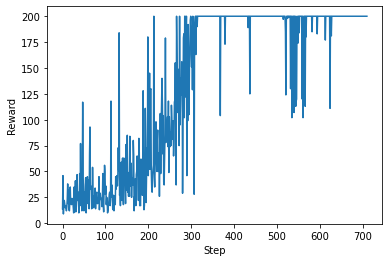

In [13]:
plot_rewards(cartpole_rewards)

## Policy Gradient on Acrobot

Now we'll run our model on Acrobot. This system consists of two joints and two links where the joint between the two links is actuated. Initially, the links are hanging downwards, and the goal is to swing the end of the lower link up to a given height as quickly as possible. You should see an average reward greater than -80 at some point during training.




In [14]:
def run_acrobot():
    config = {
        'seed': 1,
        'env_name': 'Acrobot-v1',
        'lr': 3e-2,
        'num_batches': 300,
        'batch_size': 1000,
        'max_ep_len': 1000,
        'gamma': 1.0,
        'policy_net_func': create_mlp_policy_net,
        'baseline_net_func': create_mlp_baseline_net,
        'use_baseline': True,
        'normalize_advantage': True,
        'device': device,
        'video': True,
        'video_freq': 50,
    }
    
    torch.manual_seed(config['seed'])
    np.random.seed(config['seed'])
    random.seed(config['seed'])
    
    env = gym.make(config['env_name'])
    pg_agent, rewards = run(env, config)
    return pg_agent, rewards, env
acrobot_pg_agent, acrobot_rewards, acrobot_env = run_acrobot()

Average reward: -500.00 +/- 0.00
Showing video...


/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: -500.00 +/- 0.00


Average reward: -500.00 +/- 0.00
Average reward: -500.00 +/- 0.00
Average reward: -500.00 +/- 0.00
Average reward: -500.00 +/- 0.00
Average reward: -500.00 +/- 0.00
Average reward: -500.00 +/- 0.00
Average reward: -500.00 +/- 0.00
Average reward: -500.00 +/- 0.00
Average reward: -406.00 +/- 66.47
Average reward: -477.00 +/- 4.24
Average reward: -384.50 +/- 13.79
Average reward: -364.50 +/- 61.87
Average reward: -339.50 +/- 47.02
Average reward: -329.67 +/- 1.91
Average reward: -252.00 +/- 7.32
Average reward: -322.00 +/- 45.76
Average reward: -277.33 +/- 12.30
Average reward: -296.33 +/- 33.82
Average reward: -251.33 +/- 23.34
Average reward: -267.33 +/- 32.43
Average reward: -236.50 +/- 43.50
Average reward: -223.50 +/- 9.75
Average reward: -207.75 +/- 10.77
Average reward: -213.50 +/- 23.36
Average reward: -165.00 +/- 12.00
Average reward: -188.20 +/- 10.98
Average reward: -186.80 +/- 18.14
Average reward: -223.25 +/- 47.38
Average reward: -167.00 +/- 11.09
Average reward: -185.60 +/

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: -82.00 +/- 0.00


Average reward: -93.20 +/- 5.38
Average reward: -98.89 +/- 5.45
Average reward: -98.00 +/- 6.06
Average reward: -100.44 +/- 9.78
Average reward: -91.10 +/- 3.35
Average reward: -92.80 +/- 4.30
Average reward: -96.50 +/- 5.32
Average reward: -92.44 +/- 2.08
Average reward: -94.50 +/- 3.53
Average reward: -89.09 +/- 2.40
Average reward: -98.70 +/- 8.53
Average reward: -91.50 +/- 3.01
Average reward: -90.60 +/- 3.67
Average reward: -94.00 +/- 5.25
Average reward: -95.70 +/- 9.67
Average reward: -91.20 +/- 3.05
Average reward: -152.17 +/- 63.57
Average reward: -89.27 +/- 3.58
Average reward: -135.00 +/- 56.43
Average reward: -94.60 +/- 7.71
Average reward: -114.38 +/- 25.81
Average reward: -98.70 +/- 8.91
Average reward: -78.00 +/- 3.51
Average reward: -80.83 +/- 2.61
Average reward: -80.92 +/- 2.65
Average reward: -106.00 +/- 18.03
Average reward: -80.17 +/- 3.72
Average reward: -87.27 +/- 3.92
Average reward: -101.44 +/- 15.93
Average reward: -81.42 +/- 3.25
Average reward: -82.17 +/- 5.

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: -88.00 +/- 0.00


Average reward: -98.60 +/- 11.78
Average reward: -79.25 +/- 2.37
Average reward: -83.82 +/- 3.87
Average reward: -77.50 +/- 3.15
Average reward: -116.12 +/- 16.51
Average reward: -95.67 +/- 4.36
Average reward: -82.08 +/- 1.80
Average reward: -97.30 +/- 14.01
Average reward: -81.75 +/- 5.06
Average reward: -81.83 +/- 1.58
Average reward: -79.83 +/- 1.80
Average reward: -102.33 +/- 19.93
Average reward: -81.58 +/- 3.57
Average reward: -78.83 +/- 2.25
Average reward: -77.42 +/- 2.36
Average reward: -77.92 +/- 2.35
Average reward: -86.55 +/- 9.49
Average reward: -93.90 +/- 7.84
Average reward: -80.17 +/- 3.82
Average reward: -83.55 +/- 3.32
Average reward: -78.92 +/- 2.27
Average reward: -89.82 +/- 7.03
Average reward: -79.08 +/- 2.07
Average reward: -78.08 +/- 2.38
Average reward: -84.27 +/- 5.04
Average reward: -84.18 +/- 4.91
Average reward: -79.17 +/- 2.39
Average reward: -84.64 +/- 2.44
Average reward: -92.90 +/- 7.23
Average reward: -78.75 +/- 3.24
Average reward: -83.55 +/- 6.48
Av

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: -72.00 +/- 0.00


Average reward: -77.80 +/- 2.71
Average reward: -83.82 +/- 3.89
Average reward: -81.50 +/- 2.97
Average reward: -89.67 +/- 11.56
Average reward: -88.09 +/- 4.22
Average reward: -97.50 +/- 14.78
Average reward: -87.64 +/- 4.99
Average reward: -86.55 +/- 5.68
Average reward: -80.17 +/- 2.03
Average reward: -82.82 +/- 2.92
Average reward: -107.89 +/- 16.44
Average reward: -97.30 +/- 8.82
Average reward: -77.17 +/- 1.33
Average reward: -83.18 +/- 3.21
Average reward: -81.92 +/- 2.19
Average reward: -91.50 +/- 8.61
Average reward: -78.33 +/- 4.61
Average reward: -80.17 +/- 2.64
Average reward: -83.73 +/- 2.55
Average reward: -83.55 +/- 7.09
Average reward: -89.18 +/- 4.79
Average reward: -78.75 +/- 2.36
Average reward: -79.58 +/- 2.44
Average reward: -80.33 +/- 2.26
Average reward: -93.90 +/- 8.08
Average reward: -92.40 +/- 5.97
Average reward: -86.36 +/- 2.16
Average reward: -93.80 +/- 8.07
Average reward: -88.09 +/- 7.98
Average reward: -84.55 +/- 6.42
Average reward: -78.17 +/- 2.73
Aver

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: -78.00 +/- 0.00


Average reward: -83.91 +/- 5.67
Average reward: -87.64 +/- 8.97
Average reward: -84.73 +/- 4.86
Average reward: -82.82 +/- 2.90
Average reward: -79.42 +/- 2.10
Average reward: -79.67 +/- 1.85
Average reward: -91.50 +/- 5.32
Average reward: -79.33 +/- 1.83
Average reward: -83.27 +/- 2.87
Average reward: -80.50 +/- 3.33
Average reward: -80.00 +/- 3.54
Average reward: -75.85 +/- 2.01
Average reward: -75.15 +/- 1.83
Average reward: -102.56 +/- 11.53
Average reward: -85.00 +/- 7.12
Average reward: -82.25 +/- 3.97
Average reward: -85.09 +/- 2.05
Average reward: -82.17 +/- 3.38
Average reward: -78.50 +/- 2.11
Average reward: -81.50 +/- 3.36
Average reward: -79.25 +/- 2.01
Average reward: -80.33 +/- 2.36
Average reward: -79.25 +/- 3.27
Average reward: -81.17 +/- 2.20
Average reward: -81.75 +/- 3.96
Average reward: -95.60 +/- 15.67
Average reward: -78.67 +/- 2.31
Average reward: -80.55 +/- 4.04
Average reward: -82.27 +/- 4.36
Average reward: -97.20 +/- 16.59
Average reward: -77.17 +/- 3.85
Aver

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: -91.00 +/- 0.00


Average reward: -80.00 +/- 3.54
Average reward: -80.25 +/- 2.06
Average reward: -78.92 +/- 2.40
Average reward: -78.42 +/- 2.94
Average reward: -82.00 +/- 5.05
Average reward: -79.67 +/- 2.13
Average reward: -80.25 +/- 1.49
Average reward: -96.50 +/- 14.32
Average reward: -83.36 +/- 2.27
Average reward: -77.58 +/- 1.50
Average reward: -82.73 +/- 1.91
Average reward: -81.08 +/- 1.92
Average reward: -84.82 +/- 4.92
Average reward: -80.08 +/- 2.17
Average reward: -86.73 +/- 5.94
Average reward: -83.91 +/- 6.93
Average reward: -80.42 +/- 1.96
Average reward: -83.55 +/- 3.21
Average reward: -81.17 +/- 2.68
Average reward: -78.25 +/- 2.26
Average reward: -89.91 +/- 9.18
Average reward: -89.45 +/- 8.19
Average reward: -79.42 +/- 2.44
Average reward: -79.17 +/- 2.59
Average reward: -80.25 +/- 2.09
Average reward: -98.30 +/- 13.24
Average reward: -85.36 +/- 3.38
Average reward: -78.83 +/- 2.18
Average reward: -82.45 +/- 2.33
Average reward: -79.75 +/- 2.93
Average reward: -75.18 +/- 1.45
Averag

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Average reward: -79.00 +/- 0.00


Done!


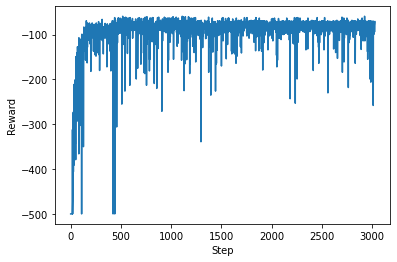

In [15]:
plot_rewards(acrobot_rewards)